In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

% matplotlib nbagg
# The three main needed variables
L = 10.0
half_L = L/2
V_MAX = 10.0
timestep = round(1/V_MAX**2, 2)
N = 10

In [20]:
class Particle(object):
    def __init__(self,p,m,v):
        if (m == 0):
            self.mass = 1.0
        else:
            self.mass = 2.0
        self.velocity = v
        self.position = round(p,3)
    
    def __str__(self):
        return format("(%f,%f,%f)" % (self.position, self.mass, self.velocity))
    
    def __repr__(self):
        return format("(%f,%f,%f)" % (self.position, self.mass, self.velocity))
    
    def move(self,time):
        self.position += round(self.velocity*time,3)
    
    def collide(self,other):
        if (type(other) is Particle or type(other) is Pipe):
            # Particle collision physics - change the velocities of both particles
            # calculate this particle's final velocity
            final_v_1 = ((2*other.mass)/(self.mass + other.mass))*other.velocity
            final_v_1 += ((self.mass - other.mass)/(other.mass + self.mass))*self.velocity
            
            # calculate the other particle's final velocity
            final_v_2 = ((2*self.mass)/(self.mass + other.mass))*self.velocity
            final_v_2 += ((other.mass - self.mass)/(other.mass + self.mass))*other.velocity

            other.velocity = final_v_2
            self.velocity = final_v_1

The above class defines a particle object which we will be using in our model of the gas in a pipe.

The below class defines the pipe itself. 

In [21]:
class Pipe(object):
    def __init__(self, l,m,cp,v):
        self.length = l
        self.mass = m
        self.center = cp
        self.velocity = v
    def move(self,time):
        self.center += self.velocity*time
    def __str__(self):
        return format("(%f,%f,%f,%f)" % (self.length, self.mass, self.center,self.velocity))

In [22]:
def hitsWall(particle, pipe):
    answer = (pipe.center - particle.position) > (pipe.center - 0.001)  
    answer = answer or particle.position > (half_L+pipe.center)-0.001
    return answer

def hitsParticle(part_1, part_2):
    return part_1.velocity > part_2.velocity and abs(part_1.position - part_2.position) < 0.001

We now define our situation. We will create an even number n of particles inside a pipe of length L. These particles will be given random positions to the left half of the pipe's center, random velocities between zero and some maximum, which will define our time step, and random masses of either m1 or m2 where m2 is twice m1.

Now that we have our particles and pipe made, we can simulate what will happen. WE will see what happens to each particle, and the pipe, in increments of 1/V_MAX seconds. 

In [46]:
possible_velocities = []

i = -V_MAX
while i < V_MAX:
    possible_velocities.append(i)
    i += timestep

# build the particles
particles = []
for i in range (0,N):
    velocity = possible_velocities[int(random.random()*len(possible_velocities))]
    particles.append(Particle(round(random.random()*half_L,1), 
                     random.randint(0,1), 
                     velocity))

# build the pipe 
pipe = Pipe(L, 1000.0,half_L,0.0)

In [47]:
def calculatePositions():
    global particles
    
    positions = []
    
    for p in particles:
        positions.append(p.position)
        p.move(timestep)
        
    return positions

In [48]:
def calculateCollisions():
    global particles
    
    i = 0
    while i < N:
        p = particles[i]
        q = particles[i+1]
        
        if (hitsParticle(p,q)):
            p.collide(q)
        i += 2

In [49]:
start_time = 0.0
stop_time = 1.0

time = start_time

positions = []

while time < stop_time:
    positions.append(calculatePositions())
    calculateCollisions()
    time += timestep

<IPython.core.display.Javascript object>


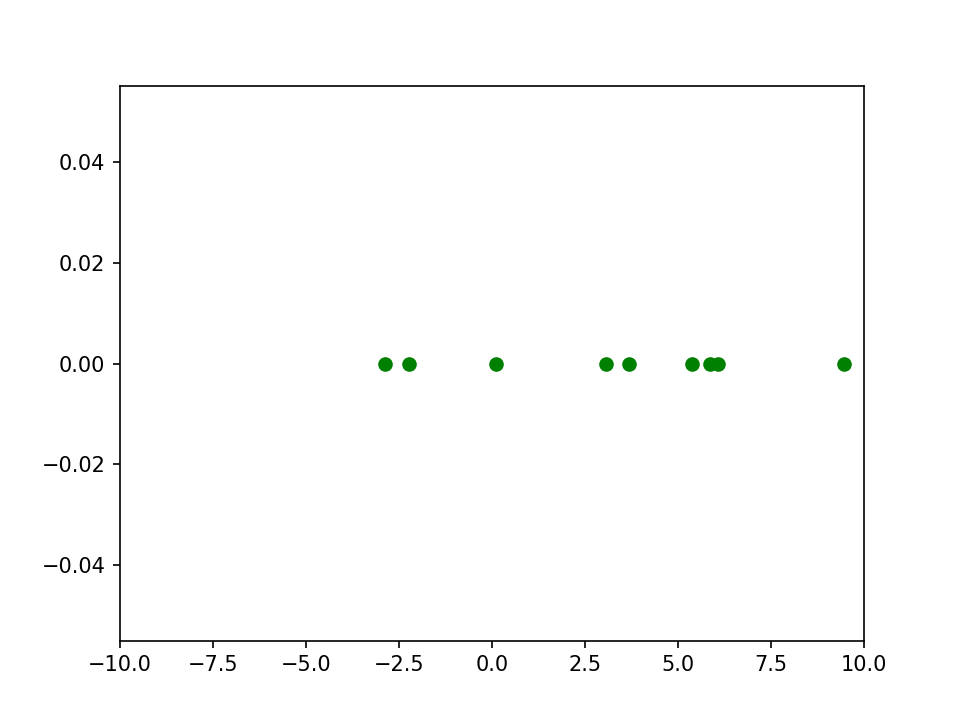

In [50]:
fig, ax = plt.subplots()
    
# create the line by making a plot of an empty space.
y = [0 for i in range(N)]
line, = ax.plot([], [], "go")
ax.set_xlim((-10,10))

# create a function to do the animation.
def animate(i):
    line.set_data(positions[i],y)  # update the data
    # return the "line generator" for handling the creation of each frame.
    return [line]

# Create the animation object which will do our animaiton.
frames = np.arange(0,int(stop_time/timestep))
ani = animation.FuncAnimation(fig, animate, frames, interval=25, blit=True)

# Display the animation
plt.show()

In [398]:
collisions = open("collisions", "w")

positions = np.ndarray((int(round(1/timestep)*stop_time),N+1))
positions_index = 1
time_index = 0
i = 0
while (i < stop_time):
    collisions.write("%f\n" % i)
    positions_index = 1
    positions[time_index][0] = i
    for part_p in particles:
        positions[time_index][positions_index] = part_p.position
        positions_index += 1
    for part_1 in particles:
        if hitsWall(part_1,pipe):
            part_1.collide(pipe)
            collisions.write("%s, wall %s\n" % (part_1, pipe))
        else:
            for part_2 in particles:
                if hitsParticle(part_1, part_2):
                    #print("before",i,part_1,part_2)
                    part_1.collide(part_2)
                    #print("after",i,part_1,part_2)
                    collisions.write("%s, %s\n" % (part_1, part_2))
                    break
    i = round(i + timestep, 2)
    time_index += 1
    for part in particles:
        part.move(timestep)
    pipe.move(timestep)

In [399]:
#print(positions)

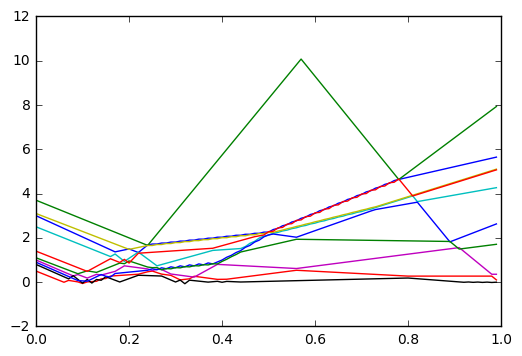

In [400]:
for i in range(1,N+1):
    plt.plot(positions[:,0],positions[:,i])
#plt.plot(positions[:,0],positions[:,3])
#plt.plot(positions[:,0],positions[:,2])
#plt.plot(positions[:,0],positions[:,1])
plt.show()